In [1]:
import os, pickle

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from sklearn.manifold import TSNE

In [2]:
pickle_file = 'all_cs_reviews'
course = 229

bert_to_be_used = 'bert-base-cased'
n_sentiment_classes = 6
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

(array([  3.,   0.,  20.,   0., 951.,   0., 238.,   0.,  59.,   8.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

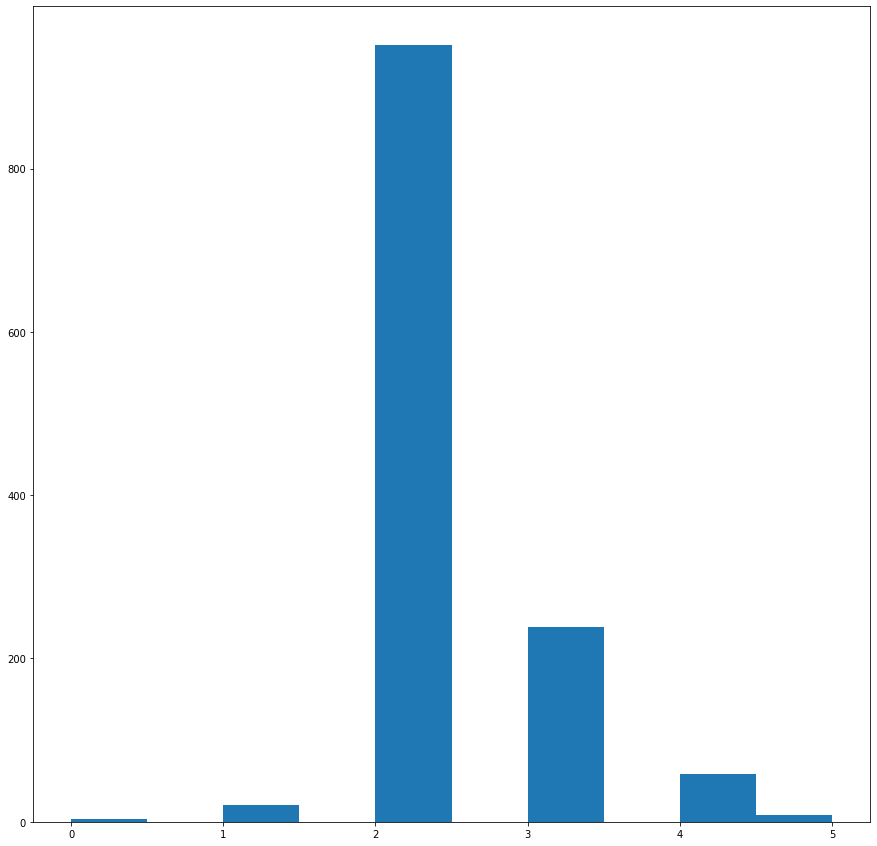

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
keywords = {
    "+ Difficulty":["very difficult", 
                  "take a lot of time",
                  "is a LOT of work", 
                  "very challenging",
                  "start assignments early", 
                  "a lot of work", 
                  "time consuming",
                  "extremely packed", 
                  "consumes a lot of time", 
                  "huge workload",
                  "challenging", 
                  "difficult", 
                  "hard", 
                  "struggle"],
    "- Difficulty":["not too much work", 
                     "not too challenging", 
                     "not to hard",
                     "easy class",
                     "small workload", 
                     "chill class", 
                     "easy course", 
                     "light workload",
                     "easy"]}
plus_one = set(keywords["+ Difficulty"])
minus_one = set(keywords["- Difficulty"])

with open(pickle_file, 'rb') as file:
    reviews = pickle.load(file)
    one_course = reviews[f'CS%20{course}']
targets = np.zeros(len(one_course))
for i, review in enumerate(one_course):
    target = 0
    for s in plus_one:
        if s in review:
            target += 1
    for s in minus_one:
        if s in review:
            target -=1
    targets[i] = target
targets += np.abs(targets.min())
plt.hist(targets)

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, reviews, tokenizer, targets):
    super().__init__()
    self.reviews = reviews
    self.tokenizer = tokenizer
    self.targets = targets
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    return self.tokenizer.encode_plus(self.reviews[item],
                                    add_special_tokens=True,
                                    return_token_type_ids=False,
                                    padding='max_length',
                                    max_length = 512,
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors='pt'), self.targets[item]

class SentimentClassifier(nn.Module):
  def __init__(self, bert_model, n_classes):
    super().__init__()
    self.bert = bert_model
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    return self.linear(self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output)

data_loader = DataLoader(ReviewDataset(one_course, BertTokenizer.from_pretrained(bert_to_be_used), targets), batch_size=batch_size)
bert_model = BertModel.from_pretrained(bert_to_be_used)
Sentiment_model = SentimentClassifier(bert_model, n_sentiment_classes).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train(model, data_loader, review_size, loss_fn, optimizer, device):
    model = model.train()  
    losses, correct = list(), 0
    
    for data_batch in data_loader:
        input_ids = data_batch[0]['input_ids'].squeeze(1).to(device)
        attention_mask = data_batch[0]['attention_mask'].squeeze(1).to(device)
        yhat = model(input_ids, attention_mask)
        _, pred = yhat.max(dim=1)
        y = data_batch[1].to(device, dtype=torch.long)
        loss = loss_fn(yhat, y)
        loss.backward()
        losses.append(loss.detach().cpu())
        optimizer.step()
        optimizer.zero_grad()
        correct += (y == pred).sum()
    
    return losses, float(correct) / review_size

def eval_model(model, data_loader, review_size, loss_fn, device):
    model = model.eval()  
    losses, correct = list(), 0
    
    with torch.no_grad():
        for data_batch in data_loader:
            input_ids = data_batch[0]['input_ids'].squeeze(1).to(device)
            attention_mask = data_batch[0]['attention_mask'].squeeze(1).to(device)
            yhat = model(input_ids, attention_mask)
            y = data_batch[1].to(device, dtype=torch.long)
            _, pred = yhat.max(dim=1)
            correct += (y == pred).sum()
    return float(correct) / review_size

In [ ]:
EPOCHS = 20
optimizer = optim.SGD(Sentiment_model.parameters(), lr=0.01, momentum=0.9)
for epoch in tqdm(range(EPOCHS)):
    losses, accuracy = train(Sentiment_model, data_loader, len(one_course), nn.CrossEntropyLoss().to(device), optimizer, device)
#     print(epoch, accuracy)

In [ ]:
outputs = None
labels = None
for data_batch in tqdm(data_loader):
    input_ids = data_batch[0]['input_ids'].squeeze(1).to(device)
    attention_mask = data_batch[0]['attention_mask'].squeeze(1).to(device)
    output = bert_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output.detach().cpu()
    outputs = output if outputs is None else torch.cat((outputs, output), dim=0)

    label = data_batch[1]
    labels  = label if labels is None else torch.cat((labels, label), dim=0)
outputs_2d = TSNE().fit_transform(outputs)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
colors = ['r', 'g', 'b', 'k', 'y', 'purple']
for t in range(0, 6):
    idx = np.where(labels == t)[0]
    plt.scatter(outputs_2d[idx, 0], outputs_2d[idx, 1], color=colors[t])